In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
import scipy.stats as stats
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif


# Load the datasets
demographic = pd.read_csv('Dataset/demographic.csv')
examination = pd.read_csv('Dataset/examination.csv')
labs = pd.read_csv('Dataset/labs.csv')
questionnaire = pd.read_csv('Dataset/questionnaire.csv')

# Select relevant features from each dataset
# Demographic features
demo_features = demographic[['SEQN', 'RIAGENDR', 'RIDAGEYR']]
# Rename demographic columns
demo_features.columns = ['ID', 'Gender', 'Age']

# Examination features
exam_features = examination[['SEQN', 'BMXBMI', 'BPXDI1']]
# Rename examination columns
exam_features.columns = ['ID', 'BMI', 'BloodPressure'] # Diastolic = 張開 ; Systolic_BP = 收縮 ; Diastolic_BP = BloodPressure In Pima

# Lab features
lab_features = labs[['SEQN', 'LBXGLT', 'LBXIN']]  # LBXIN = Insulin (uU/mL) (no specify 2Hour)
# Rename lab columns
lab_features.columns = ['ID', 'Glucose', 'Insulin']

# Questionnaire features
quest_features = questionnaire[['SEQN', 'DIQ010']]
quest_features.columns = ['ID', 'Outcome']

# Merge all datasets
merged_data = demo_features.merge(exam_features, on='ID', how='left')\
    .merge(lab_features, on='ID', how='left')\
    .merge(quest_features, on='ID', how='left')

# Create category mappings
gender_map = {1: 'Male', 2: 'Female'}


# Apply mappings
merged_data['Gender'] = merged_data['Gender'].map(gender_map)


# Convert categorical variables to dummy variables
merged_data = pd.get_dummies(merged_data, columns=['Gender'])

In [2]:
demographic

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,DMDHREDU,DMDHRMAR,DMDHSEDU,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,...,3.0,4.0,NaN,13281.237386,13481.042095,1,112,4.0,4.0,0.84
1,73558,8,2,1,54,NaN,3,3,1.0,NaN,...,3.0,1.0,1.0,23682.057386,24471.769625,1,108,7.0,7.0,1.78
2,73559,8,2,1,72,NaN,3,3,2.0,NaN,...,4.0,1.0,3.0,57214.803319,57193.285376,1,109,10.0,10.0,4.51
3,73560,8,2,1,9,NaN,3,3,1.0,119.0,...,3.0,1.0,4.0,55201.178592,55766.512438,2,109,9.0,9.0,2.52
4,73561,8,2,2,73,NaN,3,3,1.0,NaN,...,5.0,1.0,5.0,63709.667069,65541.871229,2,116,15.0,15.0,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,83727,8,2,1,26,NaN,2,2,2.0,NaN,...,3.0,NaN,NaN,27141.631824,28115.568221,1,104,77.0,77.0,NaN
10171,83728,8,2,2,2,24.0,1,1,2.0,24.0,...,3.0,1.0,3.0,15274.475360,16512.138781,1,107,8.0,8.0,1.95
10172,83729,8,2,2,42,NaN,4,4,2.0,NaN,...,5.0,3.0,NaN,24122.248900,26902.344381,1,104,7.0,7.0,3.66
10173,83730,8,2,1,7,NaN,2,2,1.0,84.0,...,4.0,1.0,3.0,25521.878546,26686.025573,2,109,6.0,6.0,1.05


# Load merged dataset information

In [4]:
# Load merged dataset information
merged_data

,ID,Age,BMI,BloodPressure,Glucose,Insulin,Outcome,Gender_Female,Gender_Male
0,73557,69,26.7,72.0,NaN,NaN,1.0,False,True
1,73558,54,28.6,62.0,NaN,NaN,1.0,False,True
2,73559,72,28.9,90.0,NaN,5.83,1.0,False,True
3,73560,9,17.1,38.0,NaN,NaN,2.0,False,True
4,73561,73,19.7,86.0,NaN,6.12,2.0,True,False
...,...,...,...,...,...,...,...,...,...
10170,83727,26,24.5,68.0,108.0,3.76,2.0,False,True
10171,83728,2,15.9,NaN,NaN,NaN,2.0,True,False
10172,83729,42,34.0,82.0,NaN,NaN,2.0,True,False
10173,83730,7,16.1,NaN,NaN,NaN,2.0,False,True


# Data type & Null count

In [6]:
# Data type & Null count
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10175 entries, 0 to 10174
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             10175 non-null  int64  
 1   Age            10175 non-null  int64  
 2   BMI            9055 non-null   float64
 3   BloodPressure  7172 non-null   float64
 4   Glucose        2345 non-null   float64
 5   Insulin        3093 non-null   float64
 6   Outcome        9769 non-null   float64
 7   Gender_Female  10175 non-null  bool   
 8   Gender_Male    10175 non-null  bool   
dtypes: bool(2), float64(5), int64(2)
memory usage: 576.4 KB


# Check for null values in the entire dataset

In [8]:
# Check for null values in the entire dataset
print("Null values in each column:")
print(merged_data.isnull().sum())

# Check for null values in specific columns
print("Null values in Age column: {0}".format(merged_data['Age'].isnull().sum()))
print("Null values in BMI column: {0}".format(merged_data['BMI'].isnull().sum()))
print("Null values in BloodPressure column: {0}".format(merged_data['BloodPressure'].isnull().sum()))
print("Null values in Glucose column: {0}".format(merged_data['Glucose'].isnull().sum()))
print("Null values in Insulin column: {0}".format(merged_data['Insulin'].isnull().sum()))


Null values in each column:
ID                  0
Age                 0
BMI              1120
BloodPressure    3003
Glucose          7830
Insulin          7082
Outcome           406
Gender_Female       0
Gender_Male         0
dtype: int64
Null values in Age column: 0
Null values in BMI column: 1120
Null values in BloodPressure column: 3003
Null values in Glucose column: 7830
Null values in Insulin column: 7082


# Fill null values with 0 in the entire dataset

In [10]:
# Fill null values with 0 in the entire dataset
merged_data = merged_data.fillna(0)

# Alternatively, fill null values with 0 in specific columns
merged_data['Age'] = merged_data['Age'].fillna(0)
merged_data['BMI'] = merged_data['BMI'].fillna(0)
merged_data['BloodPressure'] = merged_data['BloodPressure'].fillna(0)
merged_data['Glucose'] = merged_data['Glucose'].fillna(0)
merged_data['Insulin'] = merged_data['Insulin'].fillna(0)

# Check the dataset to ensure null values are replaced
print("Null values in each column after filling with 0:")
print(merged_data.isnull().sum())


Null values in each column after filling with 0:
ID               0
Age              0
BMI              0
BloodPressure    0
Glucose          0
Insulin          0
Outcome          0
Gender_Female    0
Gender_Male      0
dtype: int64


# Check if there have missing value (0) or not

In [12]:
# Check if there have missing value (0) or not
print("No. of rows with age 0 is: {0}".format(len(merged_data.loc[merged_data['Age'] == 0])))
print("No. of rows with BMI 0 is: {0}".format(len(merged_data.loc[merged_data['BMI'] == 0])))
print("No. of rows with BloodPressure 0 is: {0}".format(len(merged_data.loc[merged_data['BloodPressure'] == 0])))
print("No. of rows with Glucose value 0 is: {0}".format(len(merged_data.loc[merged_data['Glucose'] == 0])))
print("No. of rows with Insulin 0 is: {0}".format(len(merged_data.loc[merged_data['Insulin'] == 0])))

No. of rows with age 0 is: 405
No. of rows with BMI 0 is: 1120
No. of rows with BloodPressure 0 is: 3086
No. of rows with Glucose value 0 is: 7830
No. of rows with Insulin 0 is: 7082


# Identify rows where 'Glucose', 'Insulin', 'BMI", "BloodPressure" is 0

In [14]:
# Identify rows where 'Glucose', 'Insulin' is 0

zero_Glucose_rows = merged_data['Glucose'] == 0
non_zero_Glucose_rows = merged_data['Glucose'] != 0

zero_insulin_rows = merged_data['Insulin'] == 0
non_zero_insulin_rows = merged_data['Insulin'] != 0

zero_BMI_rows = merged_data['BMI'] == 0
non_zero_BMI_rows = merged_data['BMI'] != 0

zero_BloodPressure_rows = merged_data['BloodPressure'] == 0
non_zero_BloodPressure_rows = merged_data['BloodPressure'] != 0

# Features for prediction (Insulin)

In [16]:
# Features for prediction (Insulin)
features_predict_Insulin = ['Age', 'BMI', 'BloodPressure'] ## Based on Correlation Matrix before Apply Polynomial Regression

# Apply Polynomial Regression to predict missing value (Insulin)

In [18]:
# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
#poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(merged_data.loc[non_zero_insulin_rows, features_predict_Insulin])
X_poly_zero = poly.transform(merged_data.loc[zero_insulin_rows, features_predict_Insulin])

In [19]:
# Target variable
y_Insulin = merged_data.loc[non_zero_insulin_rows, 'Insulin']

In [20]:
# Train the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y_Insulin)

LinearRegression()

# Predict missing 'Insulin' values

In [22]:
# Predict missing 'Insulin' values
predicted_insulin = model.predict(X_poly_zero)

# Fill the missing 'Insulin' values

In [24]:
# Fill the missing 'Insulin' values
merged_data.loc[zero_insulin_rows, 'Insulin'] = predicted_insulin

# Check if there have missing value (0) or not

In [26]:
# Check if there have missing value (0) or not
print("No. of rows with age 0 is: {0}".format(len(merged_data.loc[merged_data['Age'] == 0])))
print("No. of rows with BMI 0 is: {0}".format(len(merged_data.loc[merged_data['BMI'] == 0])))
print("No. of rows with BloodPressure 0 is: {0}".format(len(merged_data.loc[merged_data['BloodPressure'] == 0])))
print("No. of rows with Glucose value 0 is: {0}".format(len(merged_data.loc[merged_data['Glucose'] == 0])))
print("No. of rows with Insulin 0 is: {0}".format(len(merged_data.loc[merged_data['Insulin'] == 0])))

No. of rows with age 0 is: 405
No. of rows with BMI 0 is: 1120
No. of rows with BloodPressure 0 is: 3086
No. of rows with Glucose value 0 is: 7830
No. of rows with Insulin 0 is: 0


# Features for prediction (Glucose)

In [28]:
# Features for prediction (Glucose)
features_predict_Glucose = ['Age', 'BMI', 'BloodPressure', 'Insulin'] ## Based on Correlation Matrix before Apply Polynomial Regression

# Apply Polynomial Regression to predict missing value (Glucose)

In [30]:
# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
#poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(merged_data.loc[non_zero_Glucose_rows, features_predict_Glucose])
X_poly_zero = poly.transform(merged_data.loc[zero_Glucose_rows, features_predict_Glucose])

In [31]:
# Target variable
y_Glucose = merged_data.loc[non_zero_Glucose_rows, 'Glucose']

In [32]:
# Train the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y_Glucose)

LinearRegression()

# Predict missing 'Glucose' values

In [34]:
# Predict missing 'Glucose' values
predicted_Glucose = model.predict(X_poly_zero)

# Fill the missing 'Glucose' values

In [36]:
# Fill the missing 'Glucose' values
merged_data.loc[zero_Glucose_rows, 'Glucose'] = predicted_Glucose

In [37]:
# Check if there have missing value (0) or not
print("No. of rows with age 0 is: {0}".format(len(merged_data.loc[merged_data['Age'] == 0])))
print("No. of rows with BMI 0 is: {0}".format(len(merged_data.loc[merged_data['BMI'] == 0])))
print("No. of rows with BloodPressure 0 is: {0}".format(len(merged_data.loc[merged_data['BloodPressure'] == 0])))
print("No. of rows with Glucose value 0 is: {0}".format(len(merged_data.loc[merged_data['Glucose'] == 0])))
print("No. of rows with Insulin 0 is: {0}".format(len(merged_data.loc[merged_data['Insulin'] == 0])))

No. of rows with age 0 is: 405
No. of rows with BMI 0 is: 1120
No. of rows with BloodPressure 0 is: 3086
No. of rows with Glucose value 0 is: 0
No. of rows with Insulin 0 is: 0


# Features for prediction (BMI)

In [39]:
# Features for prediction (Glucose)
features_predict_BMI = ['Age', 'BloodPressure', 'Glucose', 'Insulin'] ## Based on Correlation Matrix before Apply Polynomial Regression

# Apply Polynomial Regression to predict missing value (BMI)

In [41]:
# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
#poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(merged_data.loc[non_zero_BMI_rows, features_predict_BMI])
X_poly_zero = poly.transform(merged_data.loc[zero_BMI_rows, features_predict_BMI])

In [42]:
# Target variable
y_BMI = merged_data.loc[non_zero_BMI_rows, 'BMI']

In [43]:
# Train the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y_BMI)

LinearRegression()

# Predict missing 'BMI' values

In [45]:
# Predict missing 'BMI' values
predicted_BMI = model.predict(X_poly_zero)

# Fill the missing 'BMI' values

In [47]:
# Fill the missing 'BMI' values
merged_data.loc[zero_BMI_rows, 'BMI'] = predicted_BMI

In [48]:
# Check if there have missing value (0) or not
print("No. of rows with age 0 is: {0}".format(len(merged_data.loc[merged_data['Age'] == 0])))
print("No. of rows with BMI 0 is: {0}".format(len(merged_data.loc[merged_data['BMI'] == 0])))
print("No. of rows with BloodPressure 0 is: {0}".format(len(merged_data.loc[merged_data['BloodPressure'] == 0])))
print("No. of rows with Glucose value 0 is: {0}".format(len(merged_data.loc[merged_data['Glucose'] == 0])))
print("No. of rows with Insulin 0 is: {0}".format(len(merged_data.loc[merged_data['Insulin'] == 0])))

No. of rows with age 0 is: 405
No. of rows with BMI 0 is: 0
No. of rows with BloodPressure 0 is: 3086
No. of rows with Glucose value 0 is: 0
No. of rows with Insulin 0 is: 0


# Features for prediction (BloodPressure)

In [50]:
# Features for prediction (BloodPressure)
features_predict_BloodPressure = ['Age', 'BMI', 'Glucose', 'Insulin'] ## Based on Correlation Matrix before Apply Polynomial Regression

# Apply Polynomial Regression to predict missing value (BloodPressure)

In [52]:
# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
#poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(merged_data.loc[non_zero_BloodPressure_rows, features_predict_BloodPressure])
X_poly_zero = poly.transform(merged_data.loc[zero_BloodPressure_rows, features_predict_BloodPressure])

In [53]:
# Target variable
y_BloodPressure = merged_data.loc[non_zero_BloodPressure_rows, 'BloodPressure']

In [54]:
# Train the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y_BloodPressure)

LinearRegression()

# Predict missing 'BloodPressure' values

In [56]:
# Predict missing 'BloodPressure' values
predicted_BloodPressure = model.predict(X_poly_zero)

# Fill the missing 'BloodPressure' values

In [58]:
# Fill the missing 'BloodPressure' values
merged_data.loc[zero_BloodPressure_rows, 'BloodPressure'] = predicted_BloodPressure

In [59]:
# Check if there have missing value (0) or not
print("No. of rows with age 0 is: {0}".format(len(merged_data.loc[merged_data['Age'] == 0])))
print("No. of rows with BMI 0 is: {0}".format(len(merged_data.loc[merged_data['BMI'] == 0])))
print("No. of rows with BloodPressure 0 is: {0}".format(len(merged_data.loc[merged_data['BloodPressure'] == 0])))
print("No. of rows with Glucose value 0 is: {0}".format(len(merged_data.loc[merged_data['Glucose'] == 0])))
print("No. of rows with Insulin 0 is: {0}".format(len(merged_data.loc[merged_data['Insulin'] == 0])))

No. of rows with age 0 is: 405
No. of rows with BMI 0 is: 0
No. of rows with BloodPressure 0 is: 0
No. of rows with Glucose value 0 is: 0
No. of rows with Insulin 0 is: 0


# Load merged dataset information for checking

In [61]:
# Load merged dataset information for checking
merged_data

,ID,Age,BMI,BloodPressure,Glucose,Insulin,Outcome,Gender_Female,Gender_Male
0,73557,69,26.7,72.000000,140.142966,11.690010,1.0,False,True
1,73558,54,28.6,62.000000,120.565036,11.450715,1.0,False,True
2,73559,72,28.9,90.000000,137.576165,5.830000,1.0,False,True
3,73560,9,17.1,38.000000,91.461581,11.120771,2.0,False,True
4,73561,73,19.7,86.000000,137.916200,6.120000,2.0,True,False
...,...,...,...,...,...,...,...,...,...
10170,83727,26,24.5,68.000000,108.000000,3.760000,2.0,False,True
10171,83728,2,15.9,44.831670,95.956527,13.899938,2.0,True,False
10172,83729,42,34.0,82.000000,124.156978,16.658255,2.0,True,False
10173,83730,7,16.1,50.015263,94.608537,12.006523,2.0,False,True


# Check columns "Outcome" which larger than 2 ; 1=Get Diabetes, 2=No Diabetes

In [63]:
# Check columns "Outcome" which larger than 2 ; 1=Get Diabetes, 2=No Diabetes
print("No. of rows with Diabetes larger than 2 is: {0}".format(len(merged_data.loc[merged_data['Outcome'] >2])))

No. of rows with Diabetes larger than 2 is: 191


# Remove rows where the "Outcome" column value is greater than 2

In [65]:
# Remove rows where the "Outcome" column value is greater than 2
filtered_data = merged_data.loc[merged_data['Outcome'] <= 2]

# Remove the columns "Gender_Female" and "Gender_Male"

In [67]:
# Remove the columns "Gender_Female" and "Gender_Male"
filtered_data = filtered_data.drop(columns=['Gender_Female', 'Gender_Male'])

# Check the updated DataFrame
print("Columns after removal:")
print(filtered_data.columns)


Columns after removal:
Index(['ID', 'Age', 'BMI', 'BloodPressure', 'Glucose', 'Insulin', 'Outcome'], dtype='object')


# Remove the rows where 'Glucose' and 'Insulin' are less than or equal to 0

In [69]:
# Remove the rows where 'Glucose' and 'Insulin' are less than or equal to 0
filtered_data = filtered_data[(filtered_data['Glucose'] > 0) & (filtered_data['Insulin'] > 0)]


# Check Statistics 

In [71]:
stat_filtered_data = filtered_data.describe().style 
stat_filtered_data

,ID,Age,BMI,BloodPressure,Glucose,Insulin,Outcome
count,9857.000000,9857.000000,9857.000000,9857.000000,9857.000000,9857.000000,9857.000000
mean,78644.387237,30.744547,24.195639,61.612766,109.586133,12.865777,1.845389
std,2938.135636,24.285055,8.590048,14.507565,29.629938,8.269048,0.461634
min,73557.000000,0.000000,10.627807,4.000000,40.000000,0.032642,0.000000
25%,76095.000000,9.000000,17.600000,49.335746,94.027280,9.360000,2.000000
50%,78642.000000,25.000000,23.700000,62.000000,101.449943,11.696378,2.000000
75%,81194.000000,51.000000,29.200000,72.000000,122.225409,14.359710,2.000000
max,83731.000000,80.000000,82.900000,122.000000,604.000000,158.320000,2.000000


# Load filtered data information

In [73]:
filtered_data

,ID,Age,BMI,BloodPressure,Glucose,Insulin,Outcome
0,73557,69,26.7,72.000000,140.142966,11.690010,1.0
1,73558,54,28.6,62.000000,120.565036,11.450715,1.0
2,73559,72,28.9,90.000000,137.576165,5.830000,1.0
3,73560,9,17.1,38.000000,91.461581,11.120771,2.0
4,73561,73,19.7,86.000000,137.916200,6.120000,2.0
...,...,...,...,...,...,...,...
10170,83727,26,24.5,68.000000,108.000000,3.760000,2.0
10171,83728,2,15.9,44.831670,95.956527,13.899938,2.0
10172,83729,42,34.0,82.000000,124.156978,16.658255,2.0
10173,83730,7,16.1,50.015263,94.608537,12.006523,2.0


In [74]:
#Replace 0 if it is orginally 2
filtered_data.loc[:, 'Outcome'] = filtered_data['Outcome'].replace({2: 0})

# Check the updated values
print("Updated Outcome column values:")
print(filtered_data['Outcome'].value_counts())



Updated Outcome column values:
Outcome
0.0    9145
1.0     712
Name: count, dtype: int64


In [75]:
filtered_data

,ID,Age,BMI,BloodPressure,Glucose,Insulin,Outcome
0,73557,69,26.7,72.000000,140.142966,11.690010,1.0
1,73558,54,28.6,62.000000,120.565036,11.450715,1.0
2,73559,72,28.9,90.000000,137.576165,5.830000,1.0
3,73560,9,17.1,38.000000,91.461581,11.120771,0.0
4,73561,73,19.7,86.000000,137.916200,6.120000,0.0
...,...,...,...,...,...,...,...
10170,83727,26,24.5,68.000000,108.000000,3.760000,0.0
10171,83728,2,15.9,44.831670,95.956527,13.899938,0.0
10172,83729,42,34.0,82.000000,124.156978,16.658255,0.0
10173,83730,7,16.1,50.015263,94.608537,12.006523,0.0


# Check Normal Distribution (Q-Q plot)

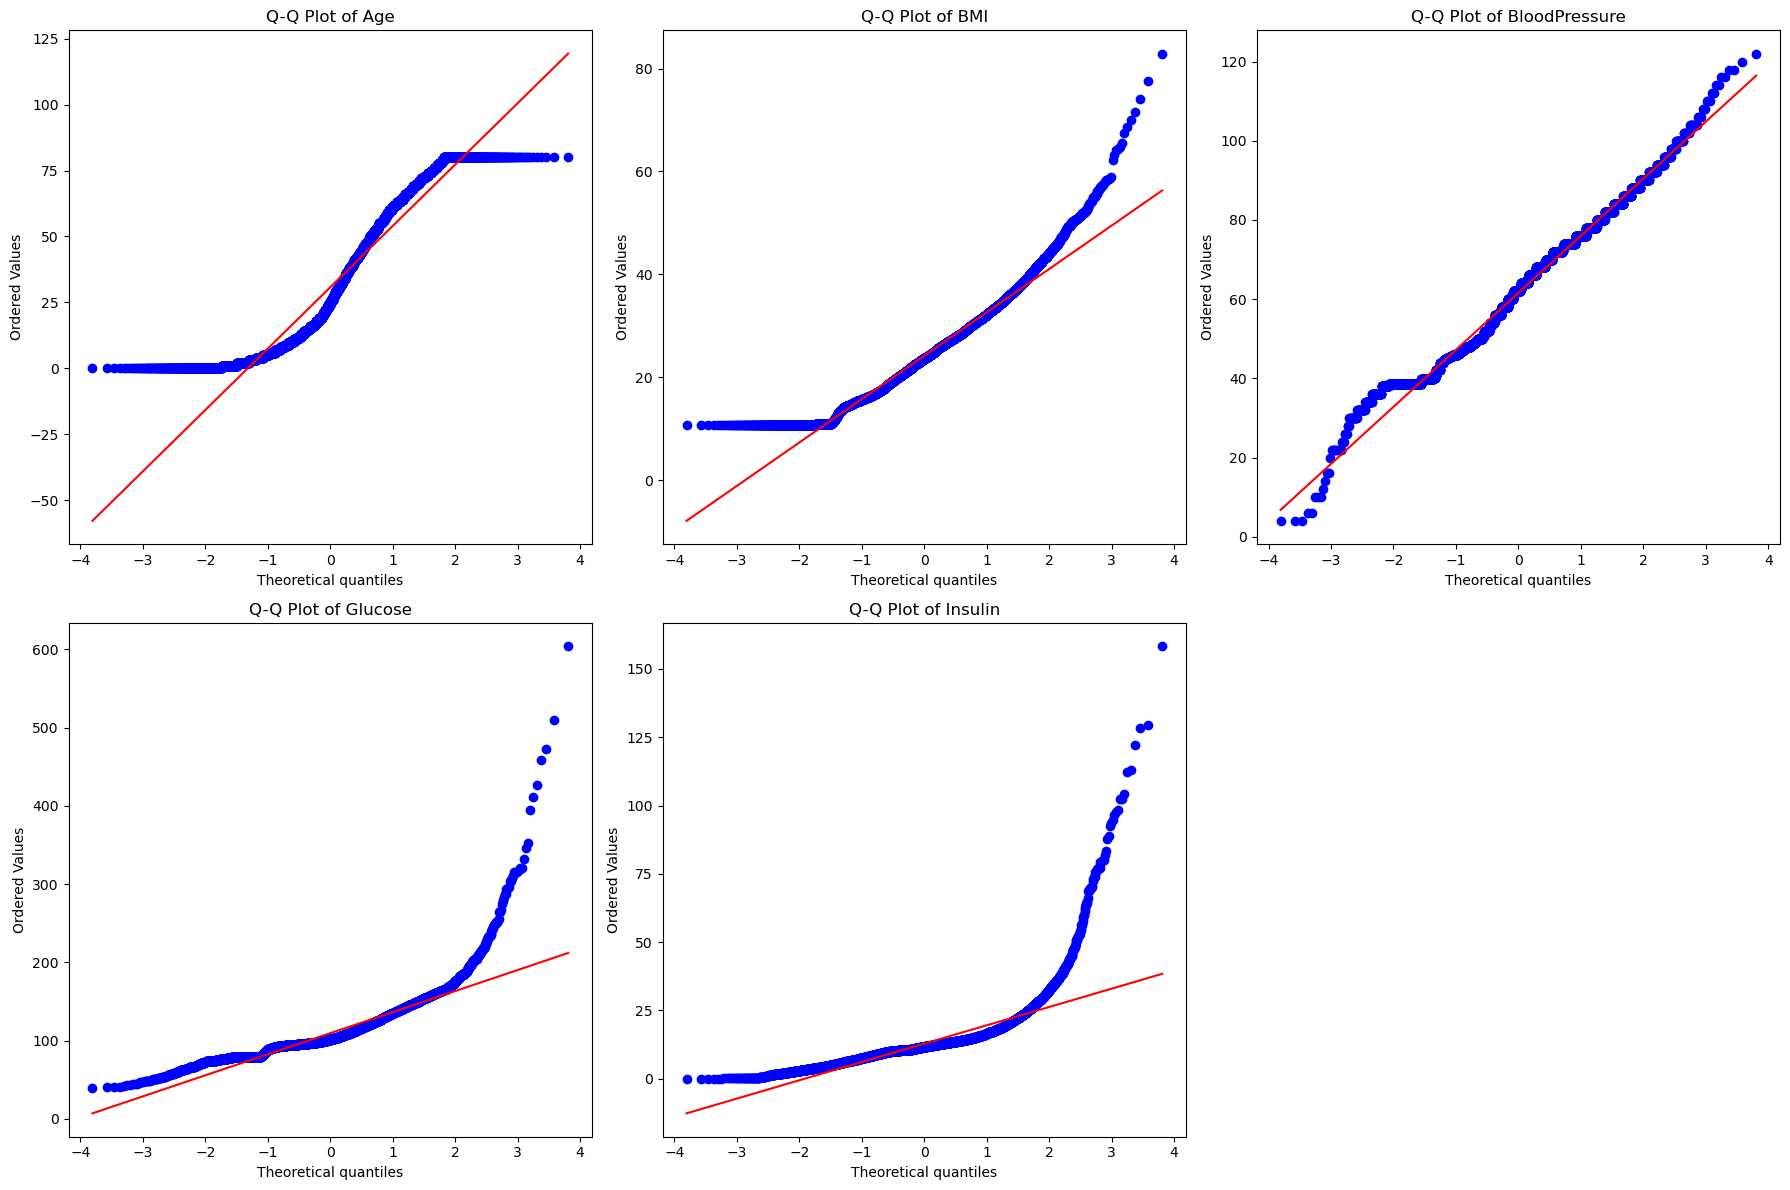

In [77]:
def qq_plot(data, feature, ax):
    stats.probplot(data[feature], dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot of {feature}')

# List of features to plot
features = ['Age', 'BMI', 'BloodPressure', 'Glucose', 'Insulin']

# Create a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# Flatten the array of axes for easier indexing
axs = axs.flatten()

# Plot Q-Q graphs for each feature
for i, feature in enumerate(features):
    qq_plot(filtered_data, feature, axs[i])

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


# Check Feature importance

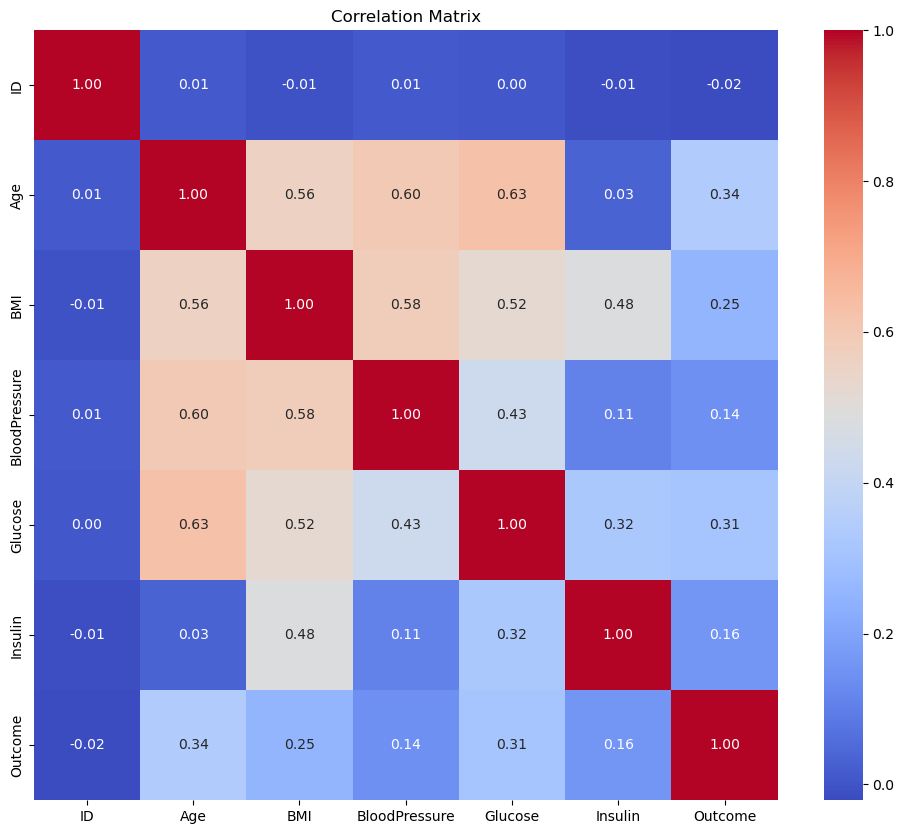

In [79]:
# Compute the correlation matrix
corr = filtered_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()


# Define Features && last column "Outcome" as Class

In [81]:
# Define Features && last column "Outcome" as Class
#selected_features = ['Glucose', 'Insulin', 'BMI', 'Age'] # 91.835% XGB & 87.37% RF &91.43%  CatBoost
selected_features = ['Glucose', 'Insulin', 'BMI', 'Age', 'BloodPressure'] # 91.987% XGB & 88.488% RF 91.58% CatBoost
#selected_features = ['Insulin', 'BMI','Age'] # 92.39% XGB & 86.51% RF & 90.92%  CatBoost


X = filtered_data[selected_features]
y = filtered_data.iloc[:, -1]   # Class = "Outcome"

# Split data (80:20)

In [83]:
# Split data (80 Train: 20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,  stratify =y) # paper

# Feature Scaling (Standardization)

In [85]:
# Feature Scaling (Standardization)
scaler = StandardScaler()
#numerical_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']
#df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Fit the scaler on the training data
#X_train_scaled = scaler.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)

# Transform the testing data
#X_test_scaled = scaler.transform(X_test)
X_test = scaler.transform(X_test)

# Check Feature importance

[0.07181086 0.0161321  0.03897891 0.06256057 0.02001462]


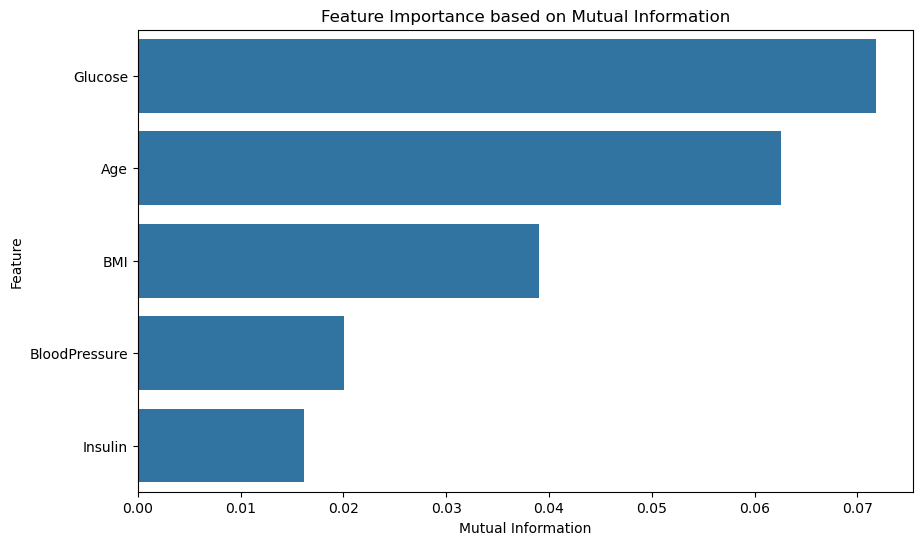

In [87]:
# Check Feature importance
# Calculate mutual information
#mi = mutual_info_classif(X_train, y_train)
mi = mutual_info_classif(X_train, y_train, random_state=42)
#mi = mutual_info_classif(X, y)
#mi = mutual_info_classif(X, y, random_state=42)
print(mi)

# Create a DataFrame for easier visualization
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi})

# Sort by importance
mi_df = mi_df.sort_values('Mutual Information', ascending=False)

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df)
plt.title('Feature Importance based on Mutual Information')
plt.show()

# Processing Imbalance data with SMOTE

In [89]:
# Processing Imbalance data with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check "Outcome" balanced or not

In [91]:
# Check "Outcome" balanced or not
y_train_smote.value_counts()

Outcome
0.0    7326
1.0    7326
Name: count, dtype: int64

# XGB

In [93]:
###The hyperparameter we got from grid search
from xgboost import XGBClassifier
#xgbc = XGBClassifier(colsample_bytree = 0.8,
# gamma= 0,
# learning_rate=0.2,                   
# max_depth= 10,
# min_child_weight= 1,
# n_estimators=100,
# subsample= 0.8,
# objective= 'binary:logistic',
# nthread= -1,
# scale_pos_weight=3).fit(X_train_smote, y_train_smote) # 87.82% 91Pre 88Recall 89F1-Score

xgbc = XGBClassifier(colsample_bytree = 0.8,
 gamma= 1,
 learning_rate=0.1,                   
 max_depth= 8,
 min_child_weight= 1,
 n_estimators=100,
 subsample= 0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(X_train, y_train) #91.987% 89Pre 92Recall 90F1-Score #selected_features = ['Glucose', 'Insulin', 'BMI', 'Age', 'BloodPressure']
                                            #92.39% 90Pre 92Recall 89F1-Score #selected_features = ['Insulin', 'BMI','Age']

In [94]:
from sklearn.metrics import accuracy_score
y_pred=xgbc.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print(classification_report(y_test, y_pred))

[[1793   26]
 [ 132   21]]
Accuracy Score 0.9198782961460447
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      1819
         1.0       0.45      0.14      0.21       153

    accuracy                           0.92      1972
   macro avg       0.69      0.56      0.58      1972
weighted avg       0.89      0.92      0.90      1972



In [95]:
from sklearn.model_selection import StratifiedKFold,cross_val_score
skfold = StratifiedKFold(n_splits=5)

cv_score = cross_val_score(xgbc,X,y,cv=skfold)
results=cv_score
print("Results = ", np.mean(results),"+/-",np.std(results))

Results =  0.9227963173932775 +/- 0.005356864855208705


## CatBoost

In [97]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# CATBoost
CATBoost = CatBoostClassifier(random_seed=42, iterations=500, learning_rate=0.1)
# lr0.1 = Acc 90.34% # lr0.15 = Acc 90.74% # lr0.2 = Acc 90.69% (both iter=500)
# lr0.1 = Acc 90.64% # lr0.15 = Acc 91.24% # lr0.2 = Acc 90.84% (both iter=1000)
# lr0.1 = Acc 91.14% # lr0.15 = Acc 91.19% # lr0.2 = Acc  90.84% (both iter=2000)
# lr0.1 = Acc 91.04% # lr0.15 = Acc 90.94% # lr0.2 = Acc  90.74% (both iter=5000)

# Fit the model
CATBoost.fit(X_train, y_train, verbose=100)

y_pred = CATBoost.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred))

0:	learn: 0.5262797	total: 144ms	remaining: 1m 12s
100:	learn: 0.1427593	total: 371ms	remaining: 1.46s
200:	learn: 0.1186647	total: 568ms	remaining: 845ms
300:	learn: 0.1004231	total: 766ms	remaining: 506ms
400:	learn: 0.0857216	total: 960ms	remaining: 237ms
499:	learn: 0.0744112	total: 1.16s	remaining: 0us
Accuracy: 91.58%
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96      1819
         1.0       0.37      0.12      0.19       153

    accuracy                           0.92      1972
   macro avg       0.65      0.55      0.57      1972
weighted avg       0.89      0.92      0.90      1972



# Random Forest

In [99]:
from sklearn.ensemble import RandomForestClassifier

# hyperparameter
#rf = RandomForestClassifier(bootstrap=True, 
#                            max_depth=10, 
#                            max_features='sqrt', 
#                            min_samples_leaf=1, 
#                            min_samples_split=2,
#                            n_estimators=100)

###The hyperparameter we got from grid search (paper setting)
rf=RandomForestClassifier(max_depth=780, max_features='log2', n_estimators=600)

# Fit the model
rf.fit(X_train_smote, y_train_smote)


RandomForestClassifier(max_depth=780, max_features='log2', n_estimators=600)

In [100]:
from sklearn.metrics import accuracy_score
y_pred=rf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print(classification_report(y_test, y_pred))
     

[[1649  170]
 [  66   87]]
Accuracy Score 0.8803245436105477
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93      1819
         1.0       0.34      0.57      0.42       153

    accuracy                           0.88      1972
   macro avg       0.65      0.74      0.68      1972
weighted avg       0.91      0.88      0.89      1972



In [101]:
skfold = StratifiedKFold(n_splits=5)

cv_score = cross_val_score(rf,X,y,cv=skfold)
results=cv_score
print("Results = ", np.mean(results),"+/-",np.std(results))

Results =  0.9209695246387014 +/- 0.006415210059898269


# AUC

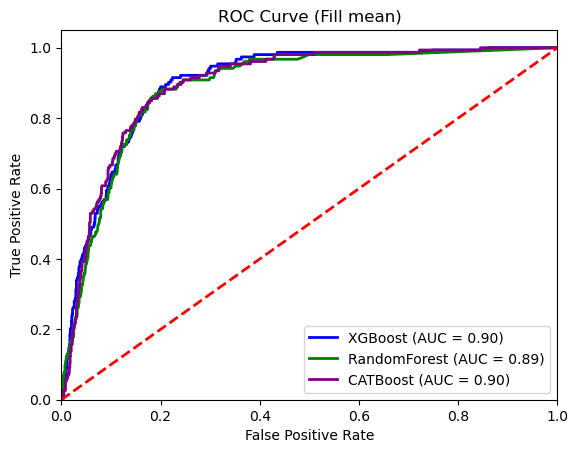

In [103]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Get predicted probabilities
xgbc_pred_proba = xgbc.predict_proba(X_test)[:, 1]
rf_pred_proba = rf.predict_proba(X_test)[:, 1]
catboost_pred_proba = CATBoost.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC for XGBoost
fpr_xgbc, tpr_xgbc, _ = roc_curve(y_test, xgbc_pred_proba)
auc_xgbc = roc_auc_score(y_test, xgbc_pred_proba)

# Calculate ROC curve and AUC for RandomForest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)
auc_rf = roc_auc_score(y_test, rf_pred_proba)

# Calculate ROC curve and AUC for CATBoost
fpr_catboost, tpr_catboost, _ = roc_curve(y_test, catboost_pred_proba)
auc_catboost = roc_auc_score(y_test, catboost_pred_proba)

# Plot ROC curve
plt.figure()
plt.plot(fpr_xgbc, tpr_xgbc, color='blue', lw=2, label=f'XGBoost (AUC = {auc_xgbc:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'RandomForest (AUC = {auc_rf:.2f})')
plt.plot(fpr_catboost, tpr_catboost, color='purple', lw=2, label=f'CATBoost (AUC = {auc_catboost:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Fill mean)')
plt.legend(loc="lower right")
plt.show()
